# tf2 sparse autoencoder 로 MNIST Reconstruct 

* sparse penalty 를 reconstruct error에 추가(additive)
  * 간단하게는 encoder쪽에 activity regularizer를 추가하면 됨
  * 복잡한 것은 neuron별 평균 activity mean을 구하고 이에 대해 실제 activity 분포와의 KL-divergence 최소화

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY 

GPU[0] is ready


In [5]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

# MNIST 데이터 확보

In [3]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [4]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
training_dataset

<BatchDataset shapes: (None, 784), types: tf.float32>

# 모델 정의

In [9]:
class SparseEncoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        super(SparseEncoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim,
            activation=tf.nn.relu, activity_regularizer=regularizers.l1(10e-5) # activity에 대한 sparse constraint
        )
    
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        return x

class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
        
    def call(self, encoded):
        x = self.output_layer(encoded)
        return x

class SparseAutoencoder(tf.keras.Model):
    
    def __init__(self, hidden_dim, original_dim):
        super(SparseAutoencoder, self).__init__()
        self.loss = []
        self.encoder = SparseEncoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(original_dim=original_dim)
        
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed
    
    
    
autoencoder = SparseAutoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
autoencoder.build(input_shape=(None, 784))
autoencoder.call(tf.keras.layers.Input(shape = (784)))
autoencoder.summary()
#tf.keras.utils.plot_model(autoencoder, show_shapes=True)    

Model: "sparse_autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sparse_encoder_2 (SparseEnco (None, 128)               100480    
_________________________________________________________________
decoder (Decoder)            (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


# 학습

In [10]:
def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return reconstruction_error 

def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {:.3f}'.format(epoch + 1, epochs, epoch_loss.numpy()))

opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_loop(autoencoder, opt, loss, training_dataset, epochs=max_epochs)        

Epoch 1/50. Loss: 5.150
Epoch 2/50. Loss: 3.082
Epoch 3/50. Loss: 2.958
Epoch 4/50. Loss: 2.886
Epoch 5/50. Loss: 2.872
Epoch 6/50. Loss: 2.860
Epoch 7/50. Loss: 2.828
Epoch 8/50. Loss: 2.827
Epoch 9/50. Loss: 2.802
Epoch 10/50. Loss: 2.825
Epoch 11/50. Loss: 2.798
Epoch 12/50. Loss: 2.807
Epoch 13/50. Loss: 2.797
Epoch 14/50. Loss: 2.795
Epoch 15/50. Loss: 2.822
Epoch 16/50. Loss: 2.812
Epoch 17/50. Loss: 2.778
Epoch 18/50. Loss: 2.807
Epoch 19/50. Loss: 2.803
Epoch 20/50. Loss: 2.810
Epoch 21/50. Loss: 2.802
Epoch 22/50. Loss: 2.799
Epoch 23/50. Loss: 2.789
Epoch 24/50. Loss: 2.804
Epoch 25/50. Loss: 2.792
Epoch 26/50. Loss: 2.816
Epoch 27/50. Loss: 2.793
Epoch 28/50. Loss: 2.794
Epoch 29/50. Loss: 2.781
Epoch 30/50. Loss: 2.820
Epoch 31/50. Loss: 2.771
Epoch 32/50. Loss: 2.780
Epoch 33/50. Loss: 2.801
Epoch 34/50. Loss: 2.775
Epoch 35/50. Loss: 2.814
Epoch 36/50. Loss: 2.780
Epoch 37/50. Loss: 2.806
Epoch 38/50. Loss: 2.785
Epoch 39/50. Loss: 2.773
Epoch 40/50. Loss: 2.811
Epoch 41/

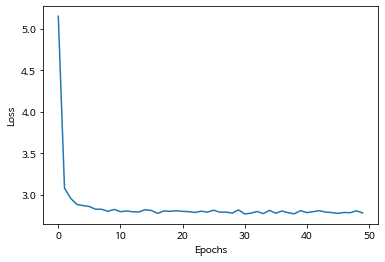

In [11]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Reconstruct 시각화

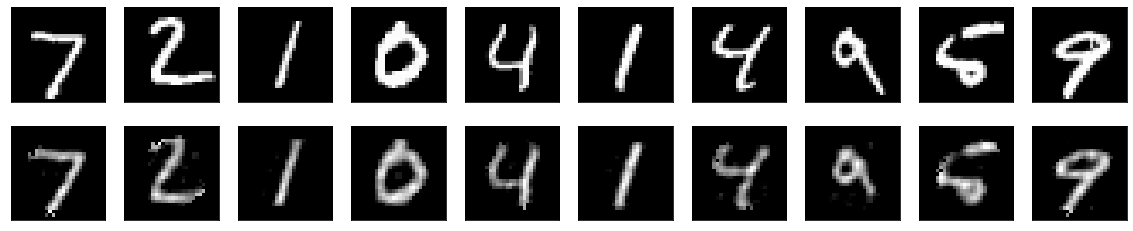

In [12]:
number = 10 
plt.figure(figsize=(20,4))
for index in range(number):
    # original
    ax = plt.subplot(2, number, index+1)
    plt.imshow(x_test[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstructed
    ax = plt.subplot(2, number, index+1+number)  # 다음 줄
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()